In [1]:
from credmark.cmf.ipython import create_cmf
from web3 import HTTPProvider, Web3

from curve_pool import CurveStableSwap
from curve_poolGamma import CurveStableSwapGamma

LINK = '0xF178C0b5Bb7e7aBF4e12A4838C7b7c5bA2C623c0'
STETH = '0xDC24316b9AE028F1497c275EB9192a3Ea0f67022'
FRAXUSDC = '0xdcef968d416a41cdac0ed8702fac8128a64241a2'
EURT = '0xfd5db7463a3ab53fd211b4af195c5bccc1a03890'
CVXETH = '0xb576491f1e6e5e62f1d8f26062ee822b40b0e0d4'

THREE_POOL = '0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7'
tricrypto2 = '0xd51a44d3fae010294c616388b506acda1bfaae46'

## Initialize CMF

In [3]:
end_block = 16024367

cmf_param = {
                'block_number': end_block
            }

context, _model_loader = create_cmf(cmf_param)
context._web3 = Web3(HTTPProvider(context.web3.provider.endpoint_uri, request_kwargs={'timeout': 3600 * 10}))
context._web3.eth.default_block = int(context.block_number)
end_block = int(context.block_number)

## Curve Sim

In [23]:
three_pool = CurveStableSwap(THREE_POOL)

print(pool_obj.balances, pool_obj.scaled_balances, pool_obj.coins_symbol)

122990396.144477 / 124696977.35454, 124696977.35454 / 445168161.909913

0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7 for 3 coins loaded
[122990396144476991977172886, 124696977354540, 445168161909913] [122990396.144477, 124696977.35454, 445168161.909913] ['DAI', 'USDC', 'USDT']


(0.9863141733964341, 0.28011207454628)

### Curve Sim for imbalance / balance

In [36]:
def imbalance(pool_obj):
    # use 1m as one exchange size

    dx_amount = 1_000_000 * 10 ** pool_obj.coins[2].decimals

    xps20 = []
    xps10 = []
    price20 = []
    price10 = []

    xp = pool_obj.balances
    while True:
        if xp[0] > 1000:
            tok0_out = pool_obj.get_dy_dx0_xp0(2, 0, dx_amount, xp)
            xps20.append([pool_obj.coins[i].scaled(v) for i, v in enumerate(xp.copy())])
            ratio20 = pool_obj.coins[0].scaled(tok0_out) / pool_obj.coins[2].scaled(dx_amount)
            price20.append(ratio20)
            xp[0] -= tok0_out
            xp[2] += dx_amount

        if xp[1] > 1000:
            tok1_out = pool_obj.get_dy_dx0_xp0(2, 1, dx_amount, xp)
            xps10.append([pool_obj.coins[i].scaled(v) for i, v in enumerate(xp.copy())])
            ratio10 = pool_obj.coins[1].scaled(tok1_out) / pool_obj.coins[2].scaled(dx_amount)
            price10.append(ratio20)
            xp[1] -= tok1_out
            xp[2] += dx_amount

        ratio_20 = pool_obj.coins[2].scaled(xp[2]) / pool_obj.coins[0].scaled(xp[0])
        ratio_21 = pool_obj.coins[2].scaled(xp[2]) / pool_obj.coins[1].scaled(xp[1])
        ratio_2torest = pool_obj.coins[2].scaled(xp[2]) / sum([pool_obj.coins[i].scaled(xp[i]) for i in range(3)])

        # print(xp, ratio_20, ratio_21)
        
        if ratio_2torest > 0.99:
            break

        if (xp[0] <= 1000 and xp[1] <= 1000):
            break

        if len(xps10) > 110:
            break

    return xps10, price10, price20

def balance(pool_obj):
    dx0_amount = 1_000_000 * 10 ** pool_obj.coins[0].decimals
    dx1_amount = 1_000_000 * 10 ** pool_obj.coins[1].decimals

    xps20 = []
    xps10 = []
    price20 = []
    price10 = []

    xp = pool_obj.balances
    while True:
        if xp[0] > 1000:
            tok2_out = pool_obj.get_dy_dx0_xp0(0, 2, dx0_amount, xp)
            xps20.append([pool_obj.coins[i].scaled(v) for i, v in enumerate(xp.copy())])
            ratio20 = pool_obj.coins[2].scaled(tok2_out) / pool_obj.coins[0].scaled(dx0_amount)
            price20.append(ratio20)
            xp[0] += dx0_amount
            xp[2] -= tok2_out

        if xp[1] > 1000:
            tok2_out = pool_obj.get_dy_dx0_xp0(1, 2, dx1_amount, xp)
            xps10.append([pool_obj.coins[i].scaled(v) for i, v in enumerate(xp.copy())])
            ratio10 = pool_obj.coins[2].scaled(tok2_out) / pool_obj.coins[1].scaled(dx1_amount)
            price10.append(ratio20)
            xp[1] += dx1_amount
            xp[2] -= tok2_out

        ratio_20 = pool_obj.coins[2].scaled(xp[2]) / pool_obj.coins[0].scaled(xp[0])
        ratio_21 = pool_obj.coins[2].scaled(xp[2]) / pool_obj.coins[1].scaled(xp[1])
        ratio_2torest = pool_obj.coins[2].scaled(xp[2]) / sum([pool_obj.coins[i].scaled(xp[i]) for i in range(3)])

        # print(xp, ratio_20, ratio_21)
        
        if ratio_2torest > 0.99:
            break

        if (xp[0] <= 1000 and xp[1] <= 1000):
            break

        if len(xps10) > 110:
            break
    
    return xps10, price10, price20

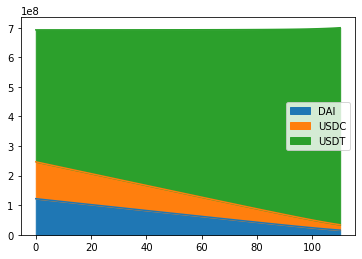

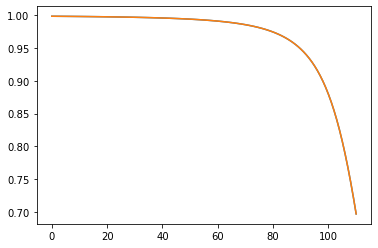

In [37]:
# USDT has about 3 time to DAI/USDC
# We simulate for 1) USDT continue to fill up the pool, and 2) USDT back to balance

# 1) imbalance
three_pool.A = 2000
xps10, price10, price20 = imbalance(three_pool)
df = pd.DataFrame(xps10, columns=three_pool.coins_symbol)
df.plot.area(); plt.show()
plt.plot(price10); plt.plot(price20); plt.show()

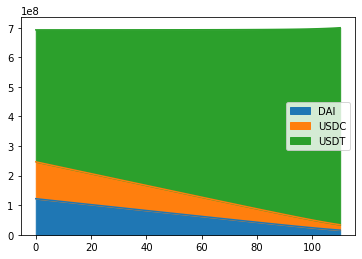

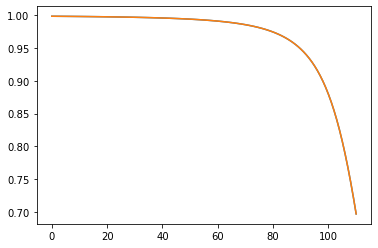

In [27]:
# USDT has about 3 time to DAI/USDC
# We simulate for 1) USDT continue to fill up the pool, and 2) USDT back to balance

# 2) balance
three_pool.A = 2000
xps10, price10, price20 = imbalance(three_pool)
df = pd.DataFrame(xps10, columns=three_pool.coins_symbol)
df.plot.area(); plt.show()
plt.plot(price10); plt.plot(price20); plt.show()

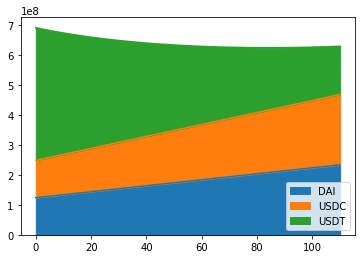

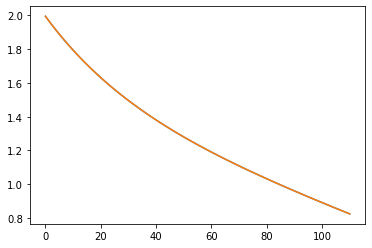

In [33]:
df = pd.DataFrame(xps10, columns=three_pool.coins_symbol)

df.plot.area(); plt.show()

plt.plot(price10); plt.plot(price20); plt.show()